In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [3]:
train_data = datasets.MNIST(
    root = "data",
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    transform = ToTensor(),
    download = True
)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [14]:
loaders = {
    "train": DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
                        
    "test": DataLoader(test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
}

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x, dim=1)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 60 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']):.0f}%)]\t{loss.item():.6f}")

def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders["test"].dataset)
    print(f"\nTest Set: Average Loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%)\n")


In [17]:
for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	2.303393
Train Epoch: 1 [6000/60000 (10%)]	1.938318
Train Epoch: 1 [12000/60000 (20%)]	1.802018
Train Epoch: 1 [18000/60000 (30%)]	1.714475
Train Epoch: 1 [24000/60000 (40%)]	1.720698
Train Epoch: 1 [30000/60000 (50%)]	1.636871
Train Epoch: 1 [36000/60000 (60%)]	1.644582
Train Epoch: 1 [42000/60000 (70%)]	1.649879
Train Epoch: 1 [48000/60000 (80%)]	1.593970
Train Epoch: 1 [54000/60000 (90%)]	1.546609

Test Set: Average Loss: 0.0153, Accuracy: 9337/10000 (93%)



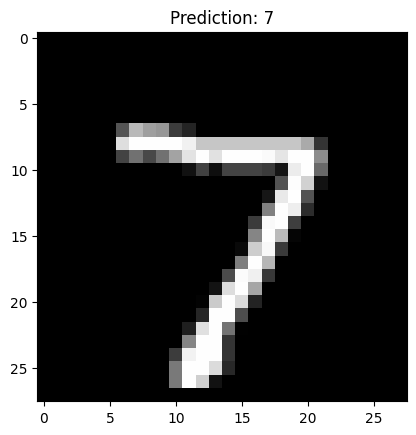

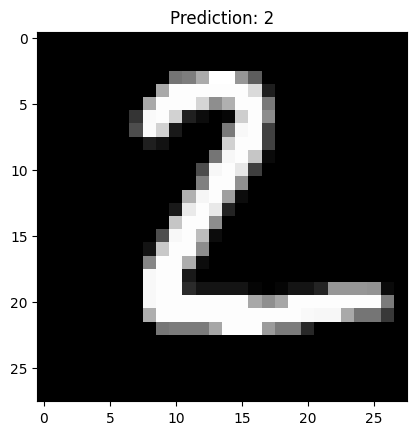

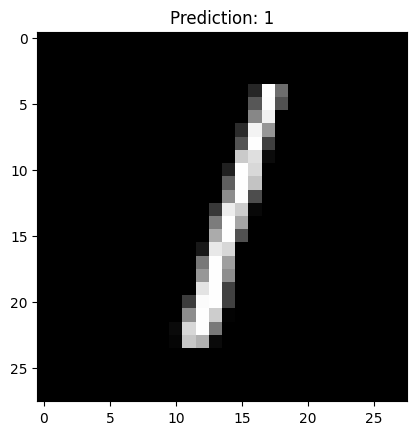

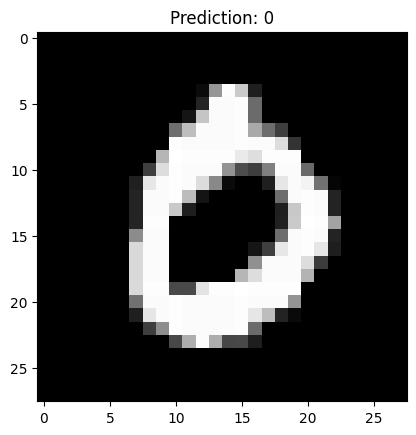

In [18]:
model.eval()

def test_prediction(test_data, idx, total_tests):
    data, target = test_data[idx]
    data = data.unsqueeze(0).to(device)
    output = model(data)
    prediction = output.argmax(dim=1, keepdim=True).item()
    image = data.squeeze(0).squeeze(0).cpu().numpy()
    plt.figure()
    plt.imshow(image, cmap="gray", interpolation='nearest')
    plt.title(f"Prediction: {prediction}")
    
    if idx == total_tests - 1:
        plt.show()
    else:
        plt.show(block=False)


total_tests = 4
for i in range(total_tests):
    test_prediction(test_data, i, total_tests)